<a href="https://colab.research.google.com/github/keirace/artificial-guacamole/blob/master/Train_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Nov 21 16:22:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import shutil
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from keras.optimizers import Adam
from tensorflow.keras.callbacks import *

In [9]:
!unrar x "/content/train.rar" "/content/train/"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/train.rar

Creating    /content/train                                            OK
Creating    /content/train/test                                       OK
Creating    /content/train/test/bad                                   OK
Extracting  /content/train/test/bad/black_bad_2020-11-18_00-50-53.015789.jpg       0%  OK 
Extracting  /content/train/test/bad/black_bad_2020-11-18_00-51-11.047060.jpg       0%  OK 
Extracting  /content/train/test/bad/black_bad_2020-11-18_00-51-22.113836.jpg       1%  OK 
Extracting  /content/train/test/bad/black_bad_2020-11-18_00-51-31.065032.jpg       1%  OK 
Extracting  /content/train/test/bad/black_bad_2020-11-18_00-51-41.241713.jpg       1%  OK 
Extracting  /content/train/test/bad/blue_bad_2020-11-18_01-46-09.283252.jpg       2%  OK 
Extracting  /content/train/test/bad/gray_bad1_2020-11-18_04-22-28.260733.jpg 

In [17]:
def dense121():
  input_shape = (224, 224, 3)
  dense_model = tf.keras.applications.DenseNet121(weights='imagenet', 
                                            include_top=False, 
                                            input_shape = input_shape)
  dense_model.trainable = False
  # for layer in dense_model.layers[int(len(dense_model.layers)*0.9):]: 
  #   layer.trainable=True

  inputs = tf.keras.Input(shape=input_shape)
  x = dense_model(inputs, training=False)
  # x = Flatten()(x)
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu', kernel_regularizer=
            tf.keras.regularizers.l2(0.001))(x)
  x = Dropout(0.25)(x)
  predictions = Dense(1, activation='sigmoid')(x)
  model = Model(inputs=inputs, outputs=predictions)

  return model

In [35]:
from os.path import join

path="/content/train"

train_path = join(path, "train")
test_path = join(path, "test")

BATCH_SIZE = 16
IMG_SIZE = (224, 224)

x_train, y_train = [], []
x_test,y_test = [], []

image_generator = ImageDataGenerator(rescale=1./255)

for file_name in glob.glob(join(train_path, "*/*.jpg")):
  img = cv2.imread(file_name)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, IMG_SIZE)
  img = np.reshape(img, (224, 224, 3))
  # img = np.reshape(img, (128, 128))
  img = np.expand_dims(img, 0)
  if file_name.split('/')[4] == "good":
    y = [1,]
    # y.append(1)
  else: y = [0,]
  # else: y.append(0)
  datagen = image_generator.flow(img, y, batch_size=1)
  batch, label = next(datagen)
  x_train.append(np.reshape(batch[0], (224, 224, 3)))
  y_train.append(label)
print(len(x_train))

for file_name in glob.glob(join(test_path, "*/*.jpg")):
  img = cv2.imread(file_name)
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, IMG_SIZE)
  img = np.reshape(img, (224, 224, 3))
  # img = np.reshape(img, (128, 128))
  img = np.expand_dims(img, 0)
  if file_name.split('/')[4] == "good":
    y = [1,]
    # y.append(1)
  else: y = [0,]
  # else: y.append(0)
  datagen = image_generator.flow(img, y, batch_size=1)
  batch, label = next(datagen)
  x_test.append(np.reshape(batch[0], (224, 224, 3)))
  y_test.append(label)
print(len(x_test))

266
52


In [36]:
from sklearn.model_selection import train_test_split
import pickle

path="/content/"

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42,
                                                  shuffle=True, test_size=0.2)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

pickle.dump(x_train, open(join(path, "x_train"),'wb'))
pickle.dump(y_train, open(join(path, "y_train"),'wb'))
pickle.dump(x_test, open(join(path, "x_test"),'wb'))
pickle.dump(y_test, open(join(path, "y_test"),'wb'))
pickle.dump(x_val, open(join(path, "x_val"),'wb'))
pickle.dump(y_val, open(join(path, "y_val"),'wb'))

# x_train = pickle.load(open(join(path, "x_train"),'rb'))
# y_train = pickle.load(open(join(path, "y_train"),'rb'))
# x_val = pickle.load(open(join(path, "x_val"),'rb'))
# y_val = pickle.load(open(join(path, "y_val"),'rb'))

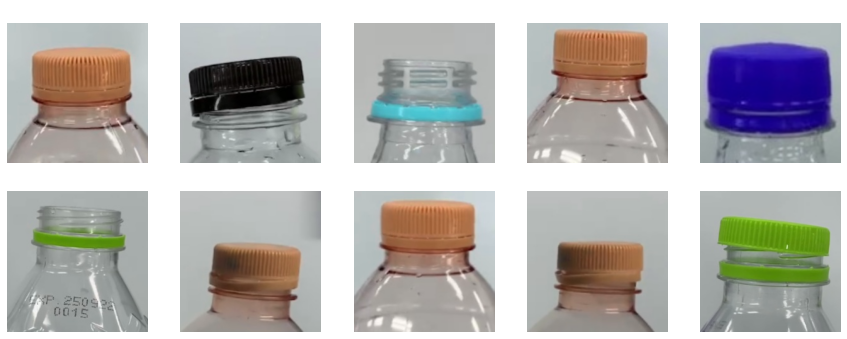

In [46]:
def show_batch():
  plt.figure(figsize=(15,15))
  for i in range(10):
      ax = plt.subplot(5,5,i+1)
      plt.imshow(x_train[i])
      plt.title(label[y_train[i][0]], color='white')
      plt.axis('off')

label = ["bad", "good"]
show_batch()

In [44]:
model = dense121()

optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6, beta_1=0.9, 
                                     beta_2=0.999, epsilon=1e-08)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                              patience=5, 
                                              restore_best_weights=True)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=3, verbose=1,factor=0.5, cooldown=2, 
    min_lr=0.0000001)

model.compile(loss='binary_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [45]:
history = model.fit(x_train, y_train, steps_per_epoch=x_train.shape[0]//BATCH_SIZE,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val), epochs=40, 
                    callbacks=[learning_rate_reduction, early_stop]
                    )

Epoch 1/40
13/13 [==============================] - 2s 175ms/step - loss: 0.9962 - accuracy: 0.6779 - val_loss: 0.7436 - val_accuracy: 0.7407
Epoch 2/40
13/13 [==============================] - 1s 65ms/step - loss: 0.5935 - accuracy: 0.8367 - val_loss: 0.5241 - val_accuracy: 0.9259
Epoch 3/40
13/13 [==============================] - 1s 63ms/step - loss: 0.4140 - accuracy: 0.9439 - val_loss: 0.4204 - val_accuracy: 0.9444
Epoch 4/40
13/13 [==============================] - 1s 64ms/step - loss: 0.3345 - accuracy: 0.9592 - val_loss: 0.3437 - val_accuracy: 0.9444
Epoch 5/40
13/13 [==============================] - 1s 64ms/step - loss: 0.2949 - accuracy: 0.9694 - val_loss: 0.3336 - val_accuracy: 0.9444
Epoch 6/40
13/13 [==============================] - 1s 63ms/step - loss: 0.2653 - accuracy: 0.9694 - val_loss: 0.2797 - val_accuracy: 0.9630
Epoch 7/40
13/13 [==============================] - 1s 62ms/step - loss: 0.2333 - accuracy: 0.9898 - val_loss: 0.2633 - val_accuracy: 0.9815
Epoch 8/40
1

In [47]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 1s 341ms/step - loss: 0.1744 - accuracy: 0.9615


[0.17441831529140472, 0.9615384340286255]

In [53]:
model.save(join("/content/drive/MyDrive", "dense_model"))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/dense_model/assets


Classification Report :
              precision    recall  f1-score   support

         bad     1.0000    0.9231    0.9600        26
        good     0.9286    1.0000    0.9630        26

    accuracy                         0.9615        52
   macro avg     0.9643    0.9615    0.9615        52
weighted avg     0.9643    0.9615    0.9615        52



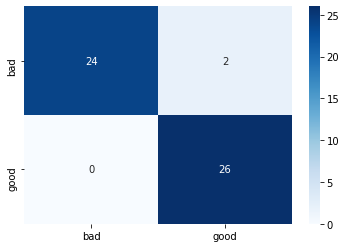

In [49]:
y_pred = np.multiply((model.predict(x_test) > 0.5), 1)
y_pred = np.array(y_pred)

CLASS_NAMES = np.array(['bad', 'good'])

#Confusion matrix, Accuracy, sensitivity and specificity
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(index=CLASS_NAMES,columns=CLASS_NAMES,data=cm),annot=True,cmap='Blues')
# total=sum(sum(cm))
# accuracy=(cm[0,0]+cm[1,1]+cm[2,2])/total
# print ('Accuracy : {:.4f}' .format(accuracy))

print( 'Classification Report :')
print(sklearn.metrics.classification_report(y_test, y_pred, target_names=CLASS_NAMES, digits=4))